In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import xgboost as xgb
from scipy.sparse import csr_matrix
from sklearn.metrics import ndcg_score
from sklearn.metrics import matthews_corrcoef
import timeit
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [3]:
train_data = pd.read_csv(r'data\train_data_preprocessed_norm2.csv')

In [5]:
from scipy.sparse import csr_matrix
import numpy as np

train_data = train_data.drop(['Unnamed: 0'], axis = 1)
train_data['score'] = np.fmax((5 * train_data['booking_bool']).values, train_data['click_bool'].values)
groups = np.array(train_data.srch_id.value_counts(sort=False).sort_index())
df_train = train_data.sort_values(by=['srch_id']).reset_index(drop=True)
print(len(groups))

#Determine training length and create train and val set

trainlength = sum(groups[0:149765])
y_train = df_train.score[0:trainlength]
y_val = df_train.score[trainlength:len(df_train)]
print('Y variables split')
X_train = csr_matrix(df_train.drop(['srch_id','score','click_bool',
                                    'booking_bool','position'],axis=1)[0:trainlength])
print('X_train made')
X_val = csr_matrix(df_train.drop(['srch_id','score','click_bool',
                                  'booking_bool','position'],axis=1)[trainlength:len(df_train)])
print('X_val made')

199795
Y variables split
X_train made
X_val made


In [8]:
import xgboost as xgb
xgb_rank = xgb.XGBRanker(n_estimators=250 ,max_depth=5,learning_rate=0.2, objective='rank:ndcg',
                                                     reg_lambda=0.2,subsample=1,gamma=0)

model = xgb_rank.fit(X_train,y_train,groups[0:149765],eval_set=[(X_val,y_val)],
                                             eval_group=[groups[149765:len(groups)].tolist()],eval_metric='ndcg',early_stopping_rounds=20)

ndcg = model.evals_result_.get('validation_0').get('ndcg')

In [9]:
model.save_model("model_norm2.json")
np.save('ncdg_norm2.npy',ndcg)

In [10]:
df_test = train_data = pd.read_csv(r'data\test_data_preprocessed_norm2.csv')
df_test = df_test.drop(['Unnamed: 0'],axis=1)

In [11]:
srch_id_list = np.unique(df_test.srch_id)
srch_id_list = np.unique(df_test.srch_id)
preds = []
ids = []
props = []

#full_predictions = pd.DataFrame(columns=['ids','props','preds'])
for i in srch_id_list:
    if i % 10000 == 0:
        print(i,' queries done')
    df_test_help = df_test.loc[df_test.srch_id==i]
    testvars = csr_matrix(df_test_help.drop(['srch_id'],axis=1))
    ids.extend(np.repeat(i,len(df_test_help)))
    predshelp = model.predict(testvars).tolist()
    propshelp = df_test_help['prop_id'].values.tolist()
    predshelp, propshelp = zip(*sorted(zip(predshelp,propshelp),reverse=True))
    props.extend(propshelp)
    preds.extend(predshelp)

full_predictions = pd.DataFrame({'srch_id': ids,
                                'prop_id': props})
full_predictions.to_csv(r'predictions\pred1_xgbranker_norm2.csv',index=False)

full_predictions

10000  queries done
30000  queries done
60000  queries done
80000  queries done
130000  queries done
150000  queries done
160000  queries done
180000  queries done
190000  queries done
200000  queries done
210000  queries done
220000  queries done
270000  queries done
280000  queries done
290000  queries done
300000  queries done
310000  queries done
320000  queries done
330000  queries done


,srch_id,prop_id
0,1,99484
1,1,54937
2,1,24194
3,1,61934
4,1,28181
...,...,...
4959178,332787,32019
4959179,332787,29018
4959180,332787,99509
4959181,332787,94437


In [13]:
train_data = df_train.drop(['srch_id','score','click_bool',
                                    'booking_bool','position'],axis=1)

In [38]:
d = {'Features': train_data.columns, 'Importances': model.feature_importances_}
df = pd.DataFrame(data=d)
df = df.sort_values(by=['Importances']).reset_index(drop=False)
df.to_csv('feat_imp.csv')

c:\Users\Pablo\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:5: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  """


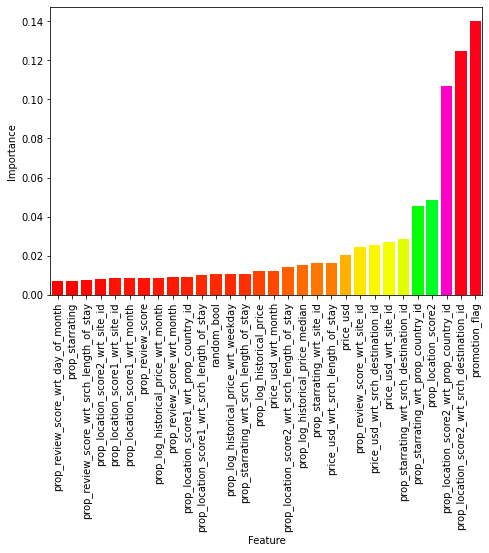

In [7]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
my_cmap = plt.get_cmap('hsv')
plt.tight_layout()
plt.margins(x = 0.003)
feat = df['Features'][-30:]
imp = df['Importances'][-30:]
plt.xticks(rotation = 'vertical')
rescale = lambda y: (y - np.min(y))/ (np.max(y)-np.mean(y))
plt.bar(feat,imp,color = my_cmap(rescale(imp)))

plt.xlabel('Feature')
plt.ylabel('Importance')
plt.savefig('Feature importances.jpg')
plt.show()


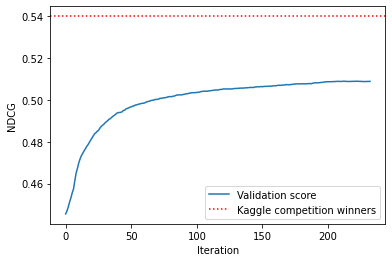

In [40]:
fig2 = plt.figure()
plt.plot(all_ndcg, label = 'Validation score')
plt.xlabel('Iteration')
plt.ylabel('NDCG')
plt.axhline(0.497, color='green', ls='dotted', label = 'Expedia benchmark')
plt.axhline(0.54, color='red', ls='dotted', label = 'Kaggle competition winners')
plt.legend(loc="lower right")
plt.show()

In [ ]:
print(matthews_corrcoef(train_data['booking_bool'], train_data['promotion_flag'], sample_weight=None))
print(matthews_corrcoef(train_data['click_bool'], train_data['promotion_flag'], sample_weight=None))

0.036046924372103266
0.03943969043442653


: 